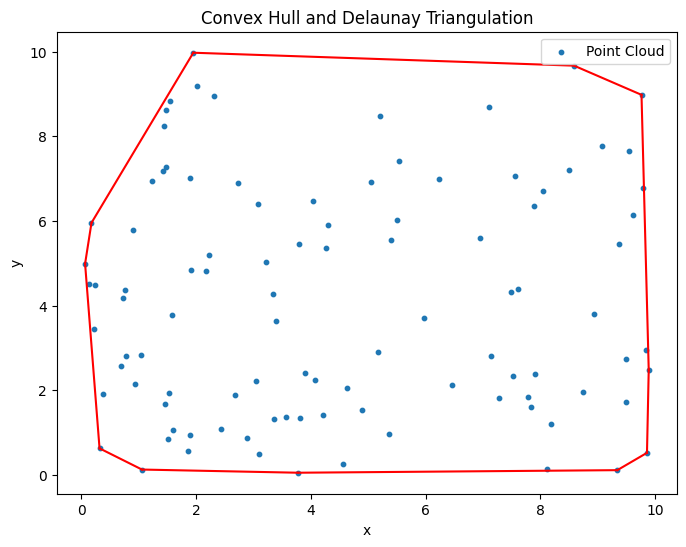

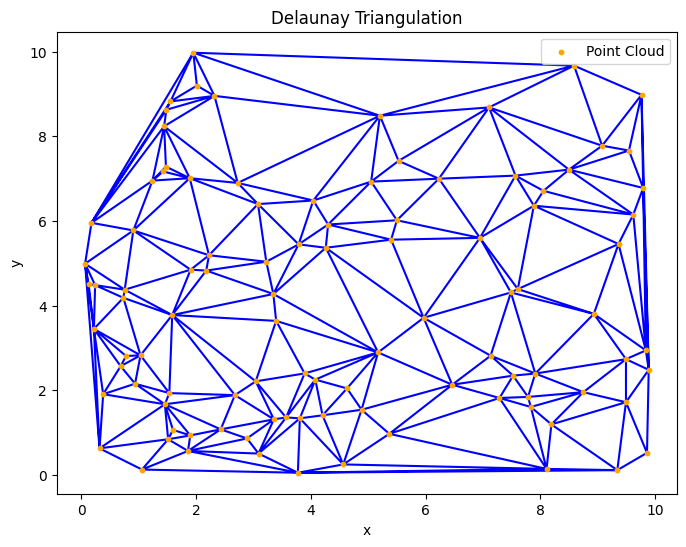

In [2]:
#a
import numpy as np
from scipy.spatial import Delaunay, ConvexHull
import matplotlib.pyplot as plt

# Load point cloud data from mesh.dat, skipping the header
point_cloud = np.loadtxt("mesh.dat", skiprows=1)

# Part (a): Plot the convex hull and Delaunay triangulation
def plot_convex_hull_and_delaunay(point_cloud):
    # Compute the convex hull
    hull = ConvexHull(point_cloud[:, :2])  # Use x and y coordinates only

    # Compute Delaunay triangulation
    delaunay = Delaunay(point_cloud[:, :2])

    # Plot the convex hull
    plt.figure(figsize=(8, 6))
    for simplex in hull.simplices:
        plt.plot(point_cloud[simplex, 0], point_cloud[simplex, 1], 'r-')
    plt.scatter(point_cloud[:, 0], point_cloud[:, 1], s=10, label="Point Cloud")
    plt.title("Convex Hull and Delaunay Triangulation")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

    # Plot Delaunay triangulation
    plt.figure(figsize=(8, 6))
    plt.triplot(point_cloud[:, 0], point_cloud[:, 1], delaunay.simplices, 'b-')
    plt.scatter(point_cloud[:, 0], point_cloud[:, 1], s=10, color='orange', label="Point Cloud")
    plt.title("Delaunay Triangulation")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

plot_convex_hull_and_delaunay(point_cloud)


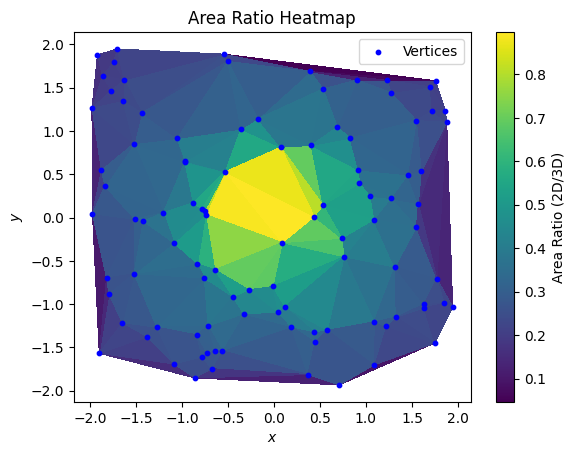

In [32]:
#b
# Define the function to calculate the surface (lifting map)
def surface(x, y):
    return x**2 + y**2

# Define the function to calculate the area of a triangle
def triangle_area(p1, p2, p3):
    # Ensure inputs are numpy arrays
    p1, p2, p3 = np.array(p1), np.array(p2), np.array(p3)
    # Compute vectors for two sides of the triangle
    v1 = p2 - p1
    v2 = p3 - p1
    # Cross product and norm
    cross_product = np.cross(v1, v2)
    return 0.5 * np.linalg.norm(cross_product)

# Generate a 2D point cloud
np.random.seed(42)  # Set seed for reproducibility
points = np.random.rand(100, 2) * 4 - 2  # Points in range [-2, 2]

# Perform Delaunay triangulation
triangles = Delaunay(points).simplices

# Calculate area ratios
colors = []
for triangle in triangles:
    # Extract the 2D triangle vertices
    p1, p2, p3 = points[triangle]
    # Calculate the original 2D area
    area = triangle_area(p1, p2, p3)
    # Lift the points to 3D and calculate the lifted area
    lifted_area = triangle_area(
        [*p1, surface(*p1)],
        [*p2, surface(*p2)],
        [*p3, surface(*p3)]
    )
    # Compute the area ratio and append to the color list
    colors.append(area / lifted_area)

# Visualize the area ratio heatmap
tpc = plt.tripcolor(points[:, 0], points[:, 1], facecolors=colors, triangles=triangles, cmap='viridis')
plt.colorbar(tpc, label="Area Ratio (2D/3D)")
plt.scatter(points[:, 0], points[:, 1], color='b', s=10, label="Vertices")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Area Ratio Heatmap")
plt.legend()
plt.show()


In [33]:
# c
# take derivative then dot product
def calculate_induced_metric(x, y):
    E = 1 + 4 * x**2
    F = 4 * x * y
    G = 1 + 4 * y**2
    return np.array([[E, F], [F, G]])

# Example usage
x, y = 1.0, 1.0
metric = calculate_induced_metric(x, y)
print("Induced Metric at (x, y) = (1.0, 1.0):")
print(metric)

Induced Metric at (x, y) = (1.0, 1.0):
[[5. 4.]
 [4. 5.]]


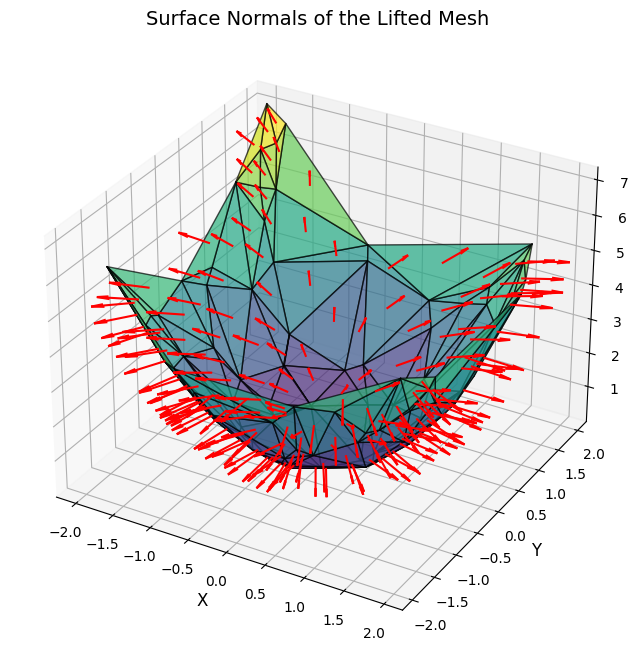

In [34]:
#d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from numpy import cross, vstack

# Function to calculate the normal of a triangle
def triangle_normal(p1, p2, p3):
    normal = cross(p3 - p1, p2 - p1)
    return normal / np.linalg.norm(normal)

# Function to calculate the centroid of a triangle
def center(p1, p2, p3):
    return (p1 + p2 + p3) / 3

# Convert 2D points to 3D by applying the surface function
points3d = vstack((points.T, surface(*points.T))).T

# Calculate the centroids and normals for all triangles
centers = np.array([center(*points3d[v]) for v in triangles])
normals = np.array([triangle_normal(*points3d[v]) for v in triangles])

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface mesh
ax.plot_trisurf(
    points3d[:, 0], points3d[:, 1], points3d[:, 2],
    triangles=triangles, cmap='viridis', alpha=0.7, edgecolor="k"
)

# Plot normals as red arrows
ax.quiver(
    centers[:, 0], centers[:, 1], centers[:, 2],
    normals[:, 0], normals[:, 1], normals[:, 2],
    color='r', length=0.5, linewidth=1.5, normalize=True
)

# Add labels and title for better visualization
ax.set_title("Surface Normals of the Lifted Mesh", fontsize=14)
ax.set_xlabel("X", fontsize=12)
ax.set_ylabel("Y", fontsize=12)
ax.set_zlabel("Z", fontsize=12)

plt.show()


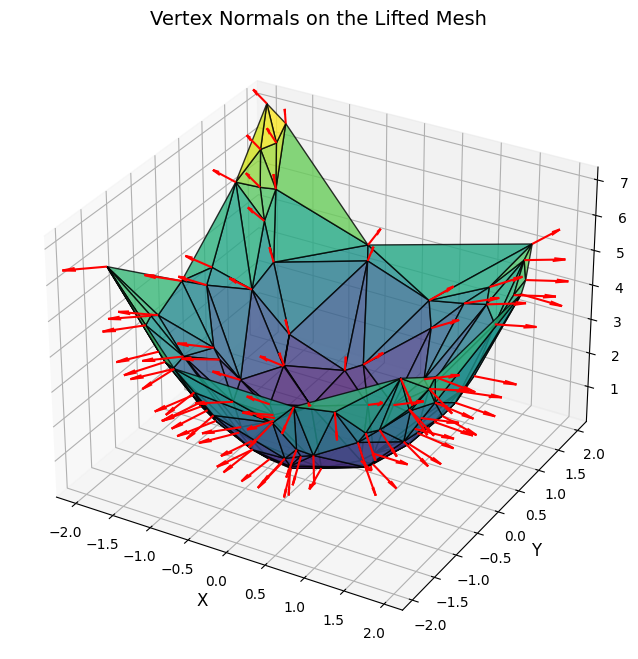

In [35]:
#e
vertex_normals = []
for i in range(len(points)):
    triangles_with_vertex = [t for t in triangles if i in t]
    # Weighted sum of triangle normals by their area
    normal = sum(
        triangle_normal(*points3d[t]) * triangle_area(*points3d[t]) for t in triangles_with_vertex
    )
    # Normalize the resulting vector
    vertex_normals.append(normal / np.linalg.norm(normal))

# Convert to array for plotting
vertex_normals = np.array(vertex_normals)

# Plot the vertex normals on the lifted surface
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(10, 8))
ax.plot_trisurf(
    *points3d.T, triangles=triangles, cmap='viridis', alpha=0.8, edgecolor="k"
)
ax.quiver(
    points3d[:, 0], points3d[:, 1], points3d[:, 2],
    vertex_normals[:, 0], vertex_normals[:, 1], vertex_normals[:, 2],
    color='r', length=0.5, normalize=True, linewidth=1.5
)
ax.set_title("Vertex Normals on the Lifted Mesh", fontsize=14)
ax.set_xlabel("X", fontsize=12)
ax.set_ylabel("Y", fontsize=12)
ax.set_zlabel("Z", fontsize=12)
plt.show()

In [ ]:
# f
def partial_derivatives(x, y):
    dx = np.array([1, 0, 2 * x])
    dy = np.array([0, 1, 2 * y])
    return dx, dy

# Calculate the second partial derivatives
def second_partial_derivatives(x, y):
    dxx = np.array([0, 0, 2])
    dyy = np.array([0, 0, 2])
    dxy = np.array([0, 0, 0])
    return dxx, dyy, dxy

# Compute the second fundamental form for each vertex
second_fundamental_forms = []
for i, vertex in enumerate(lifted_points):
    dx, dy = partial_derivatives(vertex[0], vertex[1])
    dxx, dyy, dxy = second_partial_derivatives(vertex[0], vertex[1])
    normal = vertex_normals[i]
    second_fundamental = np.array([
        [np.dot(dxx, normal), np.dot(dxy, normal)],
        [np.dot(dxy, normal), np.dot(dyy, normal)]
    ])
    second_fundamental_forms.append(second_fundamental)

second_fundamental_forms


[array([[-0.59585043,  0.        ],
        [ 0.        , -0.59585043]]),
 array([[-0.839518,  0.      ],
        [ 0.      , -0.839518]]),
 array([[-0.44442749,  0.        ],
        [ 0.        , -0.44442749]]),
 array([[-0.42177213,  0.        ],
        [ 0.        , -0.42177213]]),
 array([[-0.94046516,  0.        ],
        [ 0.        , -0.94046516]]),
 array([[-0.36023875,  0.        ],
        [ 0.        , -0.36023875]]),
 array([[-0.55687846,  0.        ],
        [ 0.        , -0.55687846]]),
 array([[-0.61407955,  0.        ],
        [ 0.        , -0.61407955]]),
 array([[-0.97219951,  0.        ],
        [ 0.        , -0.97219951]]),
 array([[-1.17090362,  0.        ],
        [ 0.        , -1.17090362]]),
 array([[-0.57509785,  0.        ],
        [ 0.        , -0.57509785]]),
 array([[-0.84579462,  0.        ],
        [ 0.        , -0.84579462]]),
 array([[-0.68520347,  0.        ],
        [ 0.        , -0.68520347]]),
 array([[-0.70134152,  0.        ],
        [ 

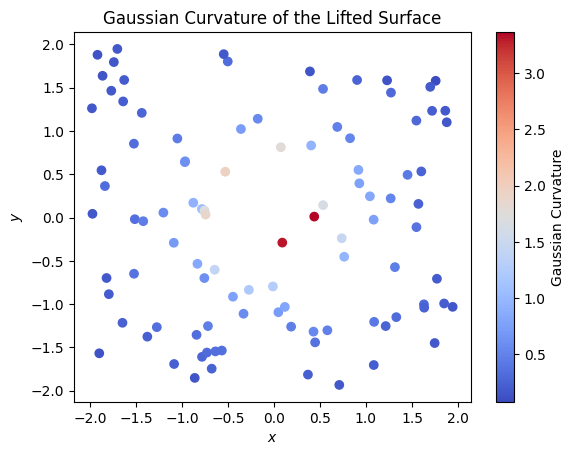

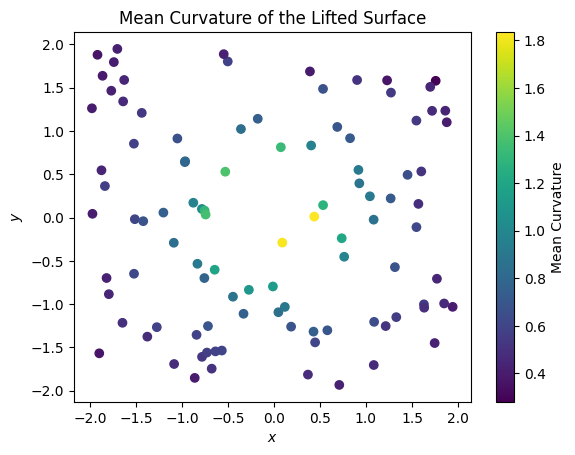

In [24]:
#g
# Compute the shape operator and curvatures
gaussian_curvatures = []
mean_curvatures = []

for i, sff in enumerate(second_fundamental_forms):
    eigenvalues, _ = np.linalg.eig(sff)
    gaussian_curvatures.append(np.prod(eigenvalues))
    mean_curvatures.append(np.mean(eigenvalues))

# Plot Gaussian curvature
plt.scatter(points[:, 0], points[:, 1], c=gaussian_curvatures, cmap='coolwarm')
plt.colorbar(label="Gaussian Curvature")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Gaussian Curvature of the Lifted Surface")
plt.show()

# Plot Mean curvature
plt.scatter(points[:, 0], points[:, 1], c=mean_curvatures, cmap='viridis')
plt.colorbar(label="Mean Curvature")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Mean Curvature of the Lifted Surface")
plt.show()


H:

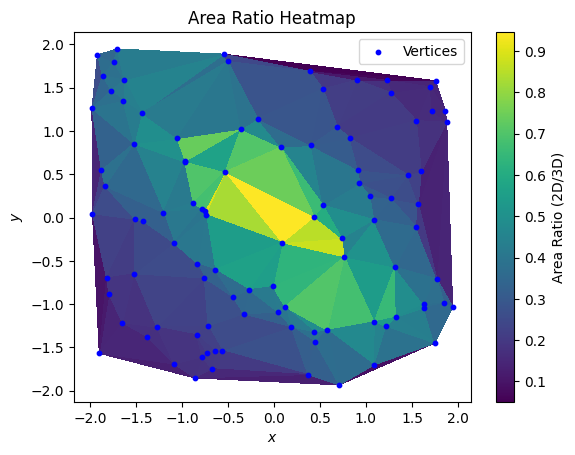

In [42]:
#b
# Define the function to calculate the surface (lifting map)
def surface(x, y):
    return x**2 + x * y + y**2

# Define the function to calculate the area of a triangle
def triangle_area(p1, p2, p3):
    # Ensure inputs are numpy arrays
    p1, p2, p3 = np.array(p1), np.array(p2), np.array(p3)
    # Compute vectors for two sides of the triangle
    v1 = p2 - p1
    v2 = p3 - p1
    # Cross product and norm
    cross_product = np.cross(v1, v2)
    return 0.5 * np.linalg.norm(cross_product)

# Generate a 2D point cloud
np.random.seed(42)  # Set seed for reproducibility
points = np.random.rand(100, 2) * 4 - 2  # Points in range [-2, 2]

# Perform Delaunay triangulation
triangles = Delaunay(points).simplices

# Calculate area ratios
colors = []
for triangle in triangles:
    # Extract the 2D triangle vertices
    p1, p2, p3 = points[triangle]
    # Calculate the original 2D area
    area = triangle_area(p1, p2, p3)
    # Lift the points to 3D and calculate the lifted area
    lifted_area = triangle_area(
        [*p1, surface(*p1)],
        [*p2, surface(*p2)],
        [*p3, surface(*p3)]
    )
    # Compute the area ratio and append to the color list
    colors.append(area / lifted_area)

# Visualize the area ratio heatmap
tpc = plt.tripcolor(points[:, 0], points[:, 1], facecolors=colors, triangles=triangles, cmap='viridis')
plt.colorbar(tpc, label="Area Ratio (2D/3D)")
plt.scatter(points[:, 0], points[:, 1], color='b', s=10, label="Vertices")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Area Ratio Heatmap")
plt.legend()
plt.show()


In [26]:
# c
# take derivative then dot product
def calculate_induced_metric(x, y):
    E = 1 + 4 * x**2
    F = 4 * x * y
    G = 1 + 4 * y**2
    return np.array([[E, F], [F, G]])

# Example usage
x, y = 1.0, 1.0
metric = calculate_induced_metric(x, y)
print("Induced Metric at (x, y) = (1.0, 1.0):")
print(metric)

Induced Metric at (x, y) = (1.0, 1.0):
[[5. 4.]
 [4. 5.]]


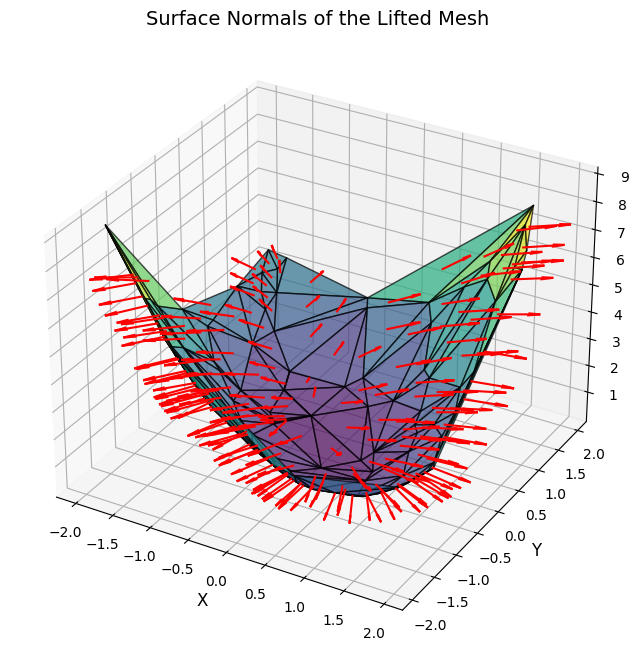

In [27]:
#d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from numpy import cross, vstack

# Function to calculate the normal of a triangle
def triangle_normal(p1, p2, p3):
    normal = cross(p3 - p1, p2 - p1)
    return normal / np.linalg.norm(normal)

# Function to calculate the centroid of a triangle
def center(p1, p2, p3):
    return (p1 + p2 + p3) / 3

# Convert 2D points to 3D by applying the surface function
points3d = vstack((points.T, surface(*points.T))).T

# Calculate the centroids and normals for all triangles
centers = np.array([center(*points3d[v]) for v in triangles])
normals = np.array([triangle_normal(*points3d[v]) for v in triangles])

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface mesh
ax.plot_trisurf(
    points3d[:, 0], points3d[:, 1], points3d[:, 2],
    triangles=triangles, cmap='viridis', alpha=0.7, edgecolor="k"
)

# Plot normals as red arrows
ax.quiver(
    centers[:, 0], centers[:, 1], centers[:, 2],
    normals[:, 0], normals[:, 1], normals[:, 2],
    color='r', length=0.5, linewidth=1.5, normalize=True
)

# Add labels and title for better visualization
ax.set_title("Surface Normals of the Lifted Mesh", fontsize=14)
ax.set_xlabel("X", fontsize=12)
ax.set_ylabel("Y", fontsize=12)
ax.set_zlabel("Z", fontsize=12)

plt.show()


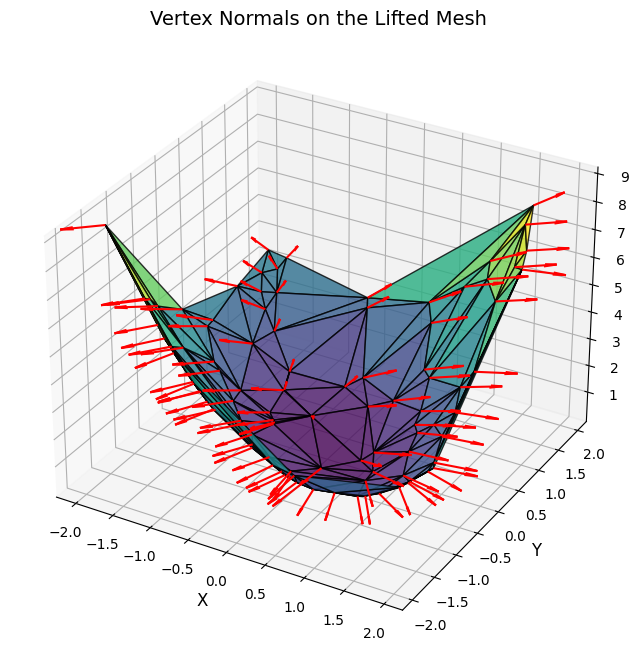

In [31]:
#e
vertex_normals = []
for i in range(len(points)):
    triangles_with_vertex = [t for t in triangles if i in t]
    # Weighted sum of triangle normals by their area
    normal = sum(
        triangle_normal(*points3d[t]) * triangle_area(*points3d[t]) for t in triangles_with_vertex
    )
    # Normalize the resulting vector
    vertex_normals.append(normal / np.linalg.norm(normal))

# Convert to array for plotting
vertex_normals = np.array(vertex_normals)

# Plot the vertex normals on the lifted surface
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(10, 8))
ax.plot_trisurf(
    *points3d.T, triangles=triangles, cmap='viridis', alpha=0.8, edgecolor="k"
)
ax.quiver(
    points3d[:, 0], points3d[:, 1], points3d[:, 2],
    vertex_normals[:, 0], vertex_normals[:, 1], vertex_normals[:, 2],
    color='r', length=0.5, normalize=True, linewidth=1.5
)
ax.set_title("Vertex Normals on the Lifted Mesh", fontsize=14)
ax.set_xlabel("X", fontsize=12)
ax.set_ylabel("Y", fontsize=12)
ax.set_zlabel("Z", fontsize=12)
plt.show()

In [50]:
#f
def surface(x, y):
    return x**2 + x * y + y**2

# Calculate partial derivatives of the lifting function dynamically from `surface()`
def partial_derivatives(x, y):
    dx = np.array([1, 0, 2 * x + y])  # ∂surface/∂x
    dy = np.array([0, 1, 2 * y + x])  # ∂surface/∂y
    return dx, dy

# Calculate the second partial derivatives dynamically from `surface()`
def second_partial_derivatives(x, y):
    dxx = np.array([0, 0, 2])  # ∂²surface/∂x²
    dyy = np.array([0, 0, 2])  # ∂²surface/∂y²
    dxy = np.array([0, 0, 1])  # ∂²surface/∂x∂y
    return dxx, dyy, dxy

# Compute the second fundamental form for each vertex
second_fundamental_forms = []
for i, vertex in enumerate(lifted_points):  # `lifted_points` contains [x, y, z] for each point
    x, y = vertex[0], vertex[1]  # Extract x and y coordinates of the vertex
    dx, dy = partial_derivatives(x, y)  # First derivatives from `surface()`
    dxx, dyy, dxy = second_partial_derivatives(x, y)  # Second derivatives
    normal = vertex_normals[i]  # Normals computed in Part (e)

    # Second fundamental form components based on the surface normal
    second_fundamental = np.array([
        [np.dot(dxx, normal), np.dot(dxy, normal)],  # L and M components
        [np.dot(dxy, normal), np.dot(dyy, normal)]   # M and N components
    ])
    second_fundamental_forms.append(second_fundamental)

# Convert to NumPy array for further processing
second_fundamental_forms = np.array(second_fundamental_forms)

print(second_fundamental_forms)  # Print first 3 second fundamental forms


First 3 Second Fundamental Forms:
[[[-0.59585043 -0.29792522]
  [-0.29792522 -0.59585043]]

 [[-0.839518   -0.419759  ]
  [-0.419759   -0.839518  ]]

 [[-0.44442749 -0.22221374]
  [-0.22221374 -0.44442749]]]


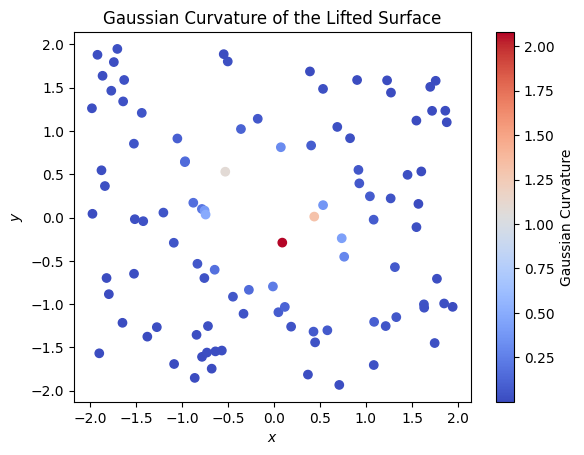

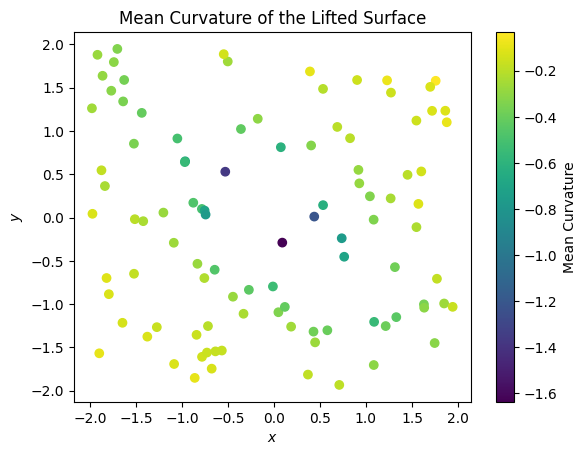

In [49]:
# g
def surface(x, y):
    return x**2 + x * y + y**2

# Calculate partial derivatives of the lifting function dynamically from `surface()`
def partial_derivatives(x, y):
    dx = np.array([1, 0, 2 * x + y])  # ∂surface/∂x
    dy = np.array([0, 1, 2 * y + x])  # ∂surface/∂y
    return dx, dy

# Calculate the second partial derivatives dynamically from `surface()`
def second_partial_derivatives(x, y):
    dxx = np.array([0, 0, 2])  # ∂²surface/∂x²
    dyy = np.array([0, 0, 2])  # ∂²surface/∂y²
    dxy = np.array([0, 0, 1])  # ∂²surface/∂x∂y
    return dxx, dyy, dxy

# Compute the first fundamental form components
def first_fundamental_form(x, y):
    dx, dy = partial_derivatives(x, y)
    E = np.dot(dx, dx)  # ∂surface/∂x ⋅ ∂surface/∂x
    F = np.dot(dx, dy)  # ∂surface/∂x ⋅ ∂surface/∂y
    G = np.dot(dy, dy)  # ∂surface/∂y ⋅ ∂surface/∂y
    return np.array([[E, F], [F, G]])

# Compute the second fundamental form components
def second_fundamental_form(x, y, normal):
    dxx, dyy, dxy = second_partial_derivatives(x, y)
    L = np.dot(dxx, normal)  # ∂²surface/∂x² ⋅ Normal
    M = np.dot(dxy, normal)  # ∂²surface/∂x∂y ⋅ Normal
    N = np.dot(dyy, normal)  # ∂²surface/∂y² ⋅ Normal
    return np.array([[L, M], [M, N]])

# Compute shape operator and curvatures
gaussian_curvatures = []
mean_curvatures = []

for i, vertex in enumerate(lifted_points):  # `lifted_points` contains [x, y, z] for each point
    x, y = vertex[0], vertex[1]
    normal = vertex_normals[i]  # Use vertex normals from Part (e)

    # Compute first and second fundamental forms
    first_form = first_fundamental_form(x, y)
    second_form = second_fundamental_form(x, y, normal)

    # Shape operator: S = I⁻¹ II
    shape_operator = np.linalg.inv(first_form) @ second_form

    # Compute eigenvalues of the shape operator
    eigenvalues, _ = np.linalg.eig(shape_operator)

    # Gaussian and mean curvatures
    gaussian_curvatures.append(np.prod(eigenvalues))  # Product of eigenvalues
    mean_curvatures.append(np.mean(eigenvalues))     # Mean of eigenvalues

# Plot Gaussian curvature
plt.scatter(points[:, 0], points[:, 1], c=gaussian_curvatures, cmap='coolwarm')
plt.colorbar(label="Gaussian Curvature")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Gaussian Curvature of the Lifted Surface")
plt.show()

# Plot Mean curvature
plt.scatter(points[:, 0], points[:, 1], c=mean_curvatures, cmap='viridis')
plt.colorbar(label="Mean Curvature")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Mean Curvature of the Lifted Surface")
plt.show()
